<a href="https://colab.research.google.com/github/JLopez86/fastbook/blob/master/03_Red_Neuronal_Convolucional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3. Red Neuronal Convolucional

##3.1. Instalación de Requerimientos

In [ ]:
# Actualización de Matplotlib
! pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.4 MB 7.1 MB/s 
     |████████████████████████████████| 295 kB 28.4 MB/s 
     |████████████████████████████████| 965 kB 53.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
# Importación de librerías
from google.colab import files
from google.colab import drive
from fastai.vision.all import *
import os
import shutil
import torch
import random
from fastai.callback.hook import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib: {}'.format(matplotlib.__version__))

# Verificación de activación de GPU
print(torch.cuda.is_available())

matplotlib: 3.6.2
False


In [ ]:
# Montar el drive y extraer el conjunto de datos
drive.mount('/content/drive')
# Descomprimir imágenes para entrenamiento y validación
! unzip /content/drive/MyDrive/Colab\ Notebooks/DPI\ -\ Anomalias\ en\ Hojas/Plant_Disease.zip
# Descomprimir imágenes para pruebas
! unzip /content/drive/MyDrive/Colab\ Notebooks/DPI\ -\ Anomalias\ en\ Hojas/Validation.zip

Archive:  /content/drive/MyDrive/Colab Notebooks/DPI - Anomalias en Hojas/Validation.zip
   creating: Validation/
   creating: Validation/Healthy/
  inflating: Validation/Healthy/9bdcc23296db1516.jpg  
  inflating: Validation/Healthy/9be41b823d13e3c6.jpg  
  inflating: Validation/Healthy/9bf9cca507923334.jpg  
  inflating: Validation/Healthy/9c3f1c10ba54ed56.jpg  
  inflating: Validation/Healthy/9c527f2a43e07a9c.jpg  
  inflating: Validation/Healthy/9c99786a63786571.jpg  
  inflating: Validation/Healthy/9cb09eb2cabfc700.jpg  
   creating: Validation/Powdery/
  inflating: Validation/Powdery/8f6737815b2cd234.jpg  
  inflating: Validation/Powdery/8fc5721dc2f293c1.jpg  
  inflating: Validation/Powdery/8fd27998ae52a4a6.jpg  
  inflating: Validation/Powdery/9a962f656993095b.jpg  
  inflating: Validation/Powdery/9a96746d61e5c43c.jpg  
  inflating: Validation/Powdery/9a9a6c25795d9e42.jpg  
  inflating: Validation/Powdery/9ab326c1951acb7a.jpg  
   creating: Validation/Rust/
  inflating: Validat

##3.2. Definición del Conjunto de Datos

In [ ]:
# Cargar el conjunto de datos en memoria
path = 'Plant_Disease'
files = get_image_files(path)

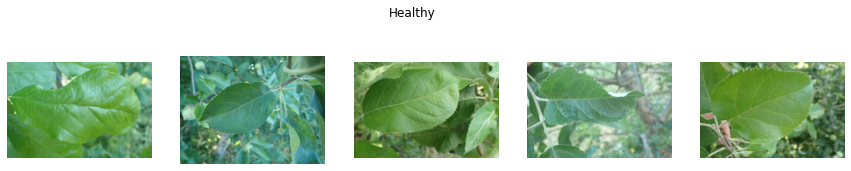

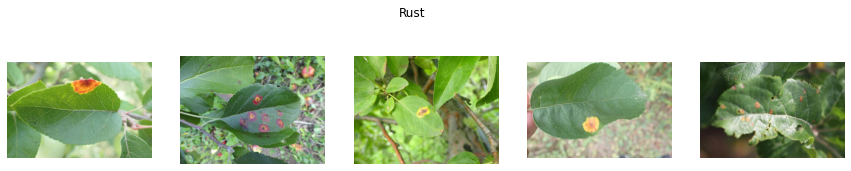

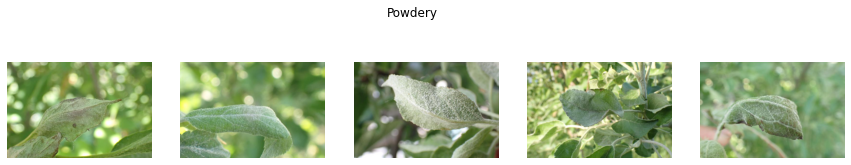

In [ ]:
# Etiquetas del dataset y visualización de las muestras
labels = os.listdir(path)
dataset = {}
for label in labels:
  images = get_image_files(path, folders=label)
  dataset[label] =len(images)
  sample = [load_image(image) for image in images.shuffle()[:5]]
  show_images(sample, nrows=1, ncols=5, imsize=3, suptitle=label)

In [ ]:
# Función para la definición del dataloader
def get_dataloader(bs = 64, size=256, val=0.20, mult=1): 
  print(f"* Cargando imágenes desde {path}:")
  print(f"    Se usará {len(labels)} etiquetas: {labels}")
  print(f"    Se reservó {1-val:.0%} de los datos para el entrenamiento")
  dataloader = ImageDataLoaders.from_folder(
  path, 
  vocab=labels, 
  item_tfms=Resize(size),
  valid_pct=val, 
  batch_tfms=aug_transforms(mult=mult),
  bs = bs,
  )
  return dataloader

dataloader = get_dataloader(val=0.20)

* Cargando imágenes desde Plant_Disease:
    Se usará 3 etiquetas: ['Healthy', 'Rust', 'Powdery']
    Se reservó 80% de los datos para el entrenamiento


In [ ]:
# Verificación de la distribución de imágenes por etiquetas para entrenamiento y validación
plot_labels = []
plot_train_imgs = []
plot_valid_imgs = []
for label in labels:
  num_train_imgs = len([path for path in dataloader.train_ds.items if path.parent.name == label])
  num_valid_imgs = len([path for path in dataloader.valid_ds.items if path.parent.name == label])
  plot_labels.append(label)
  plot_train_imgs.append(num_train_imgs)
  plot_valid_imgs.append(num_valid_imgs)
  print(f"* Para '{label}...'")
  print(f"    Se tiene {num_train_imgs} imágenes de entrenamiento")
  print(f"    Se tiene {num_valid_imgs} imágenes de validación")

* Para 'Healthy...'
    Se tiene 387 imágenes de entrenamiento
    Se tiene 121 imágenes de validación
* Para 'Rust...'
    Se tiene 393 imágenes de entrenamiento
    Se tiene 91 imágenes de validación
* Para 'Powdery...'
    Se tiene 398 imágenes de entrenamiento
    Se tiene 82 imágenes de validación


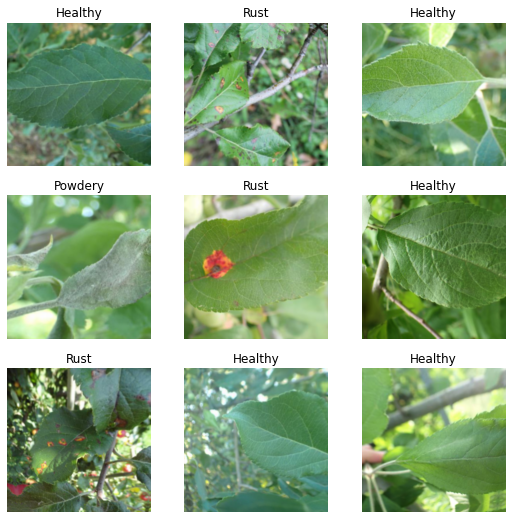

In [ ]:
dataloader.show_batch()

##4.3. Entrenamiento del Modelo

In [ ]:
# Definición inicial de Hyperparametros
epochs = 1
bs = 64
lr = 0.01

In [ ]:
# Función para la convolución
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

# Definición del modelo
def simple_cnn():
    return sequential(
        conv(3 ,8, ks=3),        
        conv(8 ,16),             
        conv(16,32),             
        conv(32,64),
        conv(64,32),   
        conv(32,16),
        conv(16,8),           
        conv(8,3, act=False),  
        Flatten(),
    )

# Definición del modelo
def get_summary():
    learn = Learner(dataloader, simple_cnn(), 
                    metrics=[accuracy, error_rate], cbs=ActivationStats(with_hist=True))
    print(learn.summary())

def fit(epochs=epochs, lr = lr):
    learn = Learner(dataloader, simple_cnn(), path='/content/', model_dir='models',  
                    metrics=[accuracy, error_rate], cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [ ]:
get_summary()

/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


Sequential (Input shape: 64 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8 x 128 x 128  
Conv2d                                    224        True      
ReLU                                                           
BatchNorm2d                               16         True      
____________________________________________________________________________
                     64 x 16 x 64 x 64   
Conv2d                                    1168       True      
ReLU                                                           
BatchNorm2d                               32         True      
____________________________________________________________________________
                     64 x 32 x 32 x 32   
Conv2d                                    4640       True      
ReLU                                                           
BatchNorm2d                               64         True      
___________________________________

In [ ]:
# Entrenamiento 1/
learn = fit()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.863184,0.909176,0.625850,0.374150,00:49


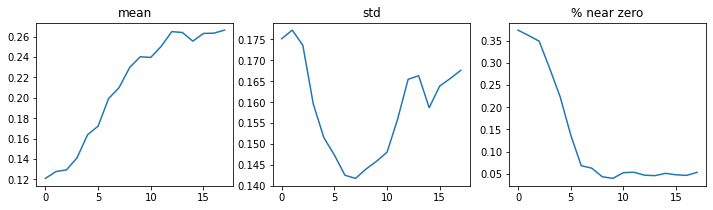

In [ ]:
learn.activation_stats.plot_layer_stats(0)

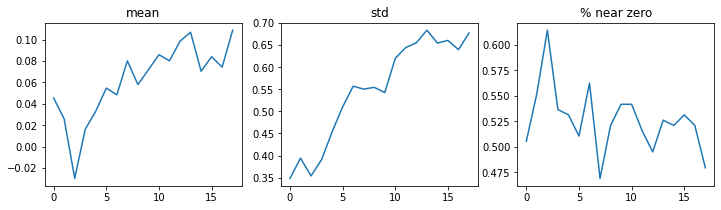

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

SuggestedLRs(valley=0.009120108559727669)

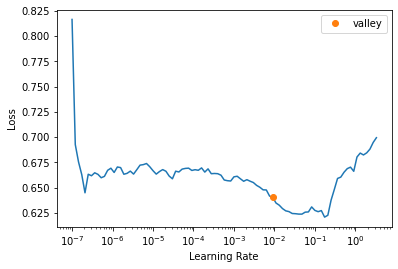

In [ ]:
# Buscando el learning rate óptimo
lr = learn.lr_find()
lr

In [ ]:
learn = fit(epochs = 10, lr = lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.040873,1.210487,0.278912,0.721088,00:36
1,0.835115,1.737790,0.472789,0.527211,00:37
2,0.679276,1.264105,0.557823,0.442177,00:37
3,0.586754,0.452474,0.843537,0.156463,00:35
4,0.512475,0.321165,0.908163,0.091837,00:38
5,0.453343,0.285364,0.908163,0.091837,00:35
6,0.392449,0.211610,0.938776,0.061224,00:35
7,0.351395,0.186141,0.955782,0.044218,00:36
8,0.312858,0.201039,0.938776,0.061224,00:36
9,0.290130,0.193392,0.952381,0.047619,00:35


##3.4. Interpretación de Resultados

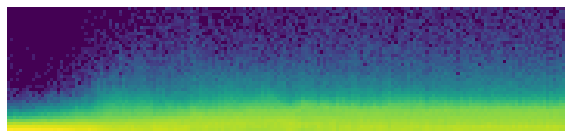

In [ ]:
learn.activation_stats.color_dim(-6)

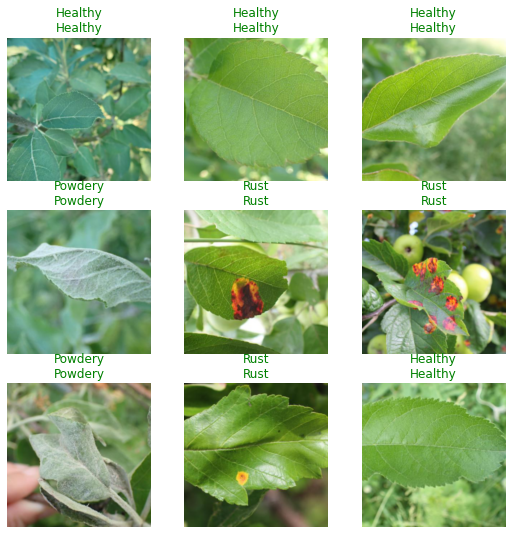

In [ ]:
learn.show_results()

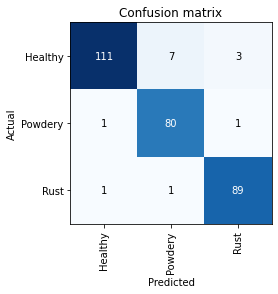

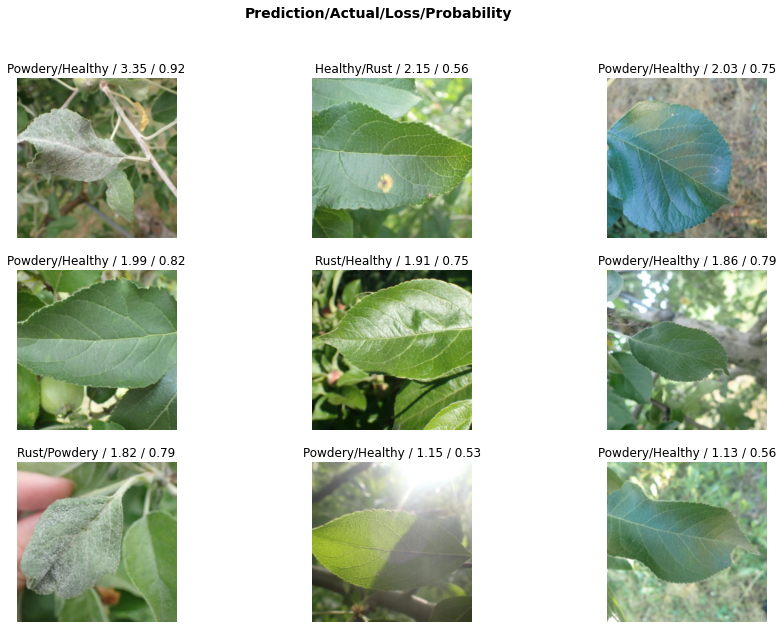

In [ ]:
learning_interpreter = ClassificationInterpretation.from_learner(learn)

# A confusion matrix will show us correct predicted vs. incorrect predictions
learning_interpreter.plot_confusion_matrix()

# We can plot the "top losses" - the higher the loss the lower the model is
# confident in the result
try:
  learning_interpreter.plot_top_losses(9, figsize=(15,10))
except:
  print('No es posible mostrar el "Plot Top Losses", el número de muestras es demasiado')

In [ ]:
# export FastAI learner
learn.export('/content/models/model_test.pkl')

##3.5. Predicción

In [ ]:
# Función para predecir imagen
def pred_img(img_path):
  dirs = os.listdir(path)
  dirs.copy()
  dirs.sort()
  img = PILImage.create(img_path)
  pred,c,probs = learn.predict(img)
  print('-'*95)
  print(f" Predicción: {pred}.")
  print(f" Probabilidad: {probs[c].item()*100:.2f}%")
  print('-'*95)
  figura = plt.figure(figsize = (12,3))
  figura.subplots_adjust(hspace=1.5, wspace=0.5)
  grafico1 = figura.add_subplot(121)
  grafico2 = figura.add_subplot(122)
  grafico1.imshow(img)
  grafico2.bar(dirs, probs.tolist(), width=.85)
  grafico1.set_title('Visualización de la Imagen')
  grafico2.set_title('Probabilidad de clases')
  grafico2.set_ylabel('Probabilidad 0 - 1')
  grafico2.set_xlabel('Etiquetas / Clases')
  plt.show()

-----------------------------------------------------------------------------------------------
 Predicción: Healthy.
 Probabilidad: 90.17%
-----------------------------------------------------------------------------------------------


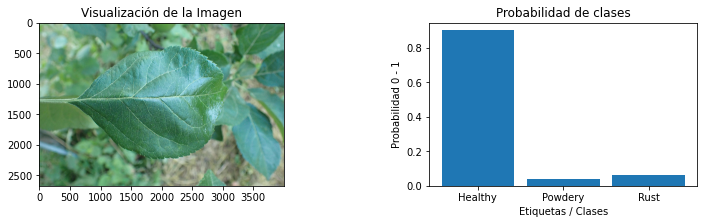

In [ ]:
# Predecir una imagen en concreto
img_path = '/content/Validation/Healthy/9bdcc23296db1516.jpg'
pred_img(img_path)

##3.6. Próximas acciones